# [MolClustPy](https://molclustpy.github.io/) Tutorial

#### Contact: achattaraj007@gmail.com

This notebook outlines different features of the Python package - [molclustpy](https://pypi.org/project/molclustpy/#description/), which is designed to analyze multivalent molecular clusters composed of multiple molecular types. This tutorial highlights how to   
* run multiple [NFsim](http://michaelsneddon.net/nfsim/) simulations of a [BioNetGen](https://bionetgen.org/) model of [multivalent protein clustering](https://elifesciences.org/articles/67176) 
* collect and analyze the NFsim output across multiple trials to extract the biophysical properties of these clusters.

**Note:** The whole pipeline is divided into multiple code blocks for the sake of visual clarity and ease of demonstration. Some of the blocks might depend on previous blocks. 

### Package Import   
* It is recommended to manage the packages via [anaconda distribution](https://www.anaconda.com/products/distribution/) which comes with most of the standard third-party packages like numpy, pandas, matplotlib etc. However, when you "pip install molclustpy", it checks for numpy, pandas and matplotlib. It will install these packages in case the machine does not have them.
* molclsutpy will automatically install [pyBioNetGen](https://pybionetgen.readthedocs.io/en/latest/)

In [1]:
from molclustpy import * # imports BNG_multiTrials, NFSim_output_analyzer, and different visualization functions 

**Example Model:** A three-component system to demonstrate the essential aspects of biomolecular clustering. Nephrin has three phosphotyrosin (pY) residues which can bind to Src Homology 2 domain (Sh2) of Nck molecule. Nck also contains three Src Homology 3 or SH3 domains (S) which interact with proline rich motif or PRM (p) of NWASP molecules. Two classes of binding rules are enough to define these reactions.  
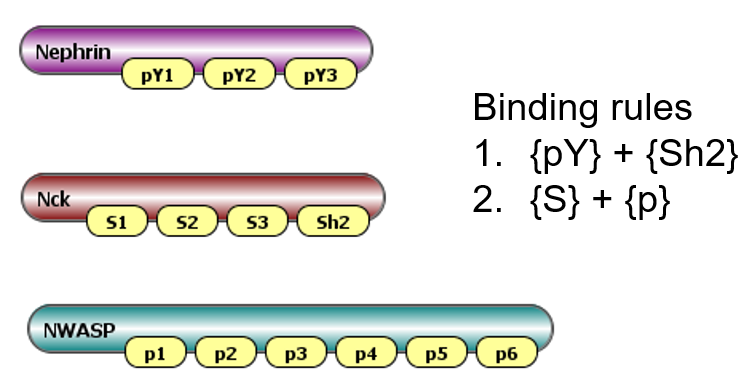

### Simulations
* Provide the path of the bngl model
* Specify the simulation details
    * duration of each simulation (*t_end*)
    * number of output points (*steps*)
    * number of stochastic trials (*numRuns*) 

Simulation output will be stored in a folder called **MyModel** if the model name is **MyModel.bngl**. There are two types of output:
* gdat files (Run_1.gdat, Run_2.gdat, ... , Run_N.gdat) containing the timeseries of observables
* species files (Run_1.species, Run_2.species, ... , Run_N.species) containing the molecular species (clusters) 

**Note:** If the folder already contains results and number of current trials is less than existing ones, then existing results will be deleted. For higher number of trials, existing trajectories will be overwritten.

In [2]:
# bngl file (BioNetGen model) 
# the bngl file location is currently same as the notebook; i.e., you have to place the bngl file in the 
# same directory with the notebook

bng_file = 'Tutorial_Nephrin_Nck_NWASP.bngl'

# Initialization of the Simulation Object
simObj = BNG_multiTrials(bng_file, t_end=0.02, steps=20, numRuns=20)
print(simObj)
simObj.runTrials(delSim=False)
print()


***** // ***** 
Class : BNG_multiTrials
File Path : Tutorial_Nephrin_Nck_NWASP.bngl

t_end : 0.02 seconds 	 output_steps : 20
Number of runs: 20

Molecules: ['NWASP', 'Nck', 'Nephrin']
Number of binding sites: [6, 4, 3]
Species Counts: [100.0, 300.0, 150.0]

NFsim progress : [****************************************] 100%
Execution time : 25.9090 seconds



### Data Analysis
NFsim_output_analyzer collects the observables and molecular clusters to perform various statistical analysis:
* Ensemble average of the observables (Enlist the observables in order to visualize in later section)
* Biophysical characterization of the molecular clusters (size distribution, composition, degree of saturation and cross-linking). In order to do these calculations, the function ( *process_speciesfiles* ) expects the following arguments
    * Name of the molecules ( *molecules* )
    * Number of molecules ( *counts* )
    * Valency or number of binding sites of each molecular type ( *numSite* )

These details are automatically filled in by parsing the input file.

**Note:** If the model contains multi-molecular species as initial conditions, then the user needs to provide the initial counts manually. 

In [3]:
# analyze data across multiple trials
outpath = simObj.getOutPath()
molecules, numSite, counts, _ = simObj.getMolecules()
nfsObj = NFSim_output_analyzer(outpath)
print(nfsObj)
nfsObj.process_gdatfiles()
nfsObj.process_speciesfiles(molecules, counts, numSite)


***** // ***** 
Class : NFSim_output_analyzer
System : Tutorial_Nephrin_Nck_NWASP
Total Trajectories : 20

Processing gdat_files : [****************************************] 100%

Observables:  {0: 'time', 1: 'tot_Nck', 2: 'free_Nck', 3: 'tot_NWASP', 4: 'free_NWASP', 5: 'tot_Nephrin', 6: 'free_Nephrin', 7: 'fully_bound_Nephrin', 8: 'fully_bound_Nck', 9: 'fully_bound_NWASP', 10: 'cluster_neph_nck_nw', 11: 'cluster_nck_nw'}

Processing species_files : [****************************************] 100%


### Visualization
### 1. Plot the observable timecourse
* A list of observables can be passed by the indexList (as printed earlier) 
* If nothing is passed, all the observables will be plotted 
* The dark line denotes the mean trajectory and the fluctuation envelop displays the standard deviation at that point

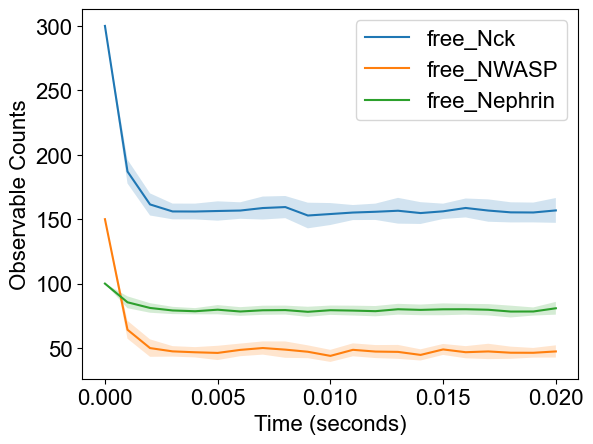

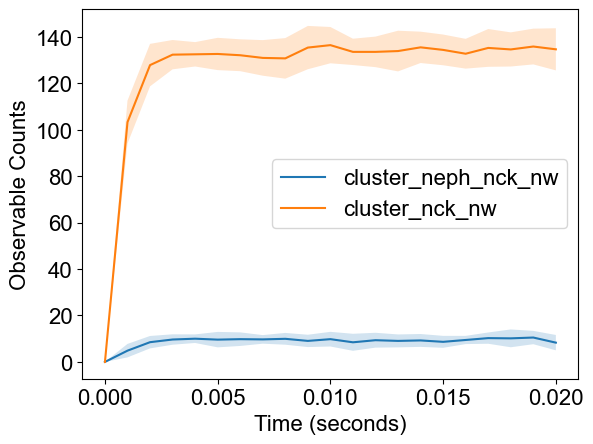

In [4]:
# indexList for observables
plotTimeCourse(outpath, obsList=[2,4,6])
plotTimeCourse(outpath, obsList=[10,11])

### 2. Plot system specific quantities

#### 2A: Cluster size distribution : 
* Fraction of total molecules vs cluster size. Mean of the distribution is called **average cluster occupancy (ACO)** as shown by the dashed line. This is a probability distribution which suggests that the **probability of finding a molecule in a cluster size 2 is 17%** if the corresponding fraction is 0.17 
* For a large cluster size range, a binned histogram might be helpful. If a system forms clusters from 10 molecules to 1000 molecules, then one might inspect the distribution at certain size ranges like *sizeRange* = [1,10,100,1000] 

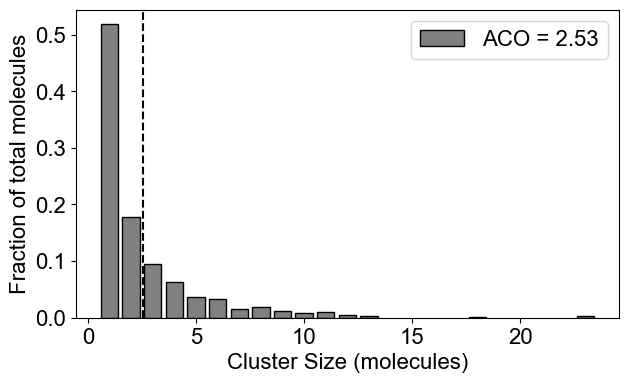

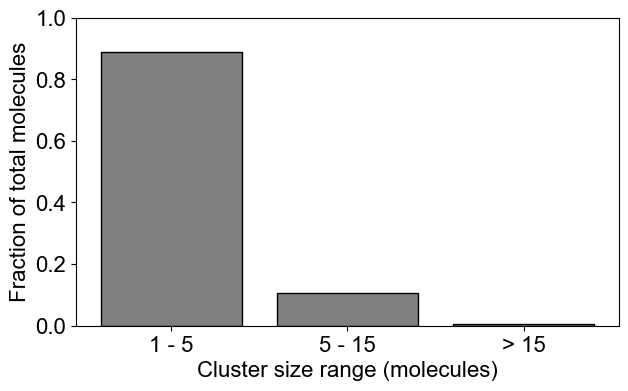

In [5]:
# 2A: Cluster size distribution (ACO: Average Cluster Occupancy)
plotClusterDist(outpath)
# Binned distribution by providing cluster size ranges
plotClusterDist(outpath, sizeRange=[1,5,15])

#### 2B: Number of bonds per molecule
Average degree of cross-linking. Number of bonds coming out of individual molecules at steady state. 

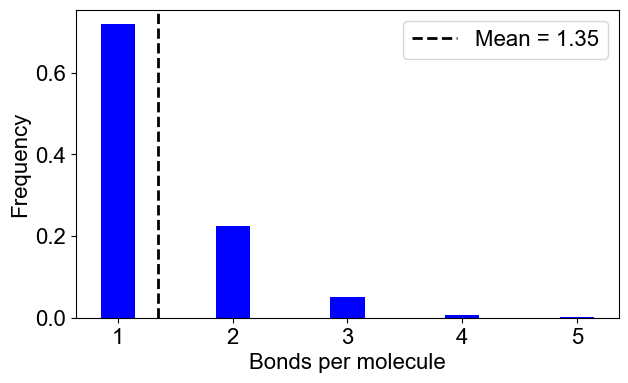

In [6]:
# 2B: Number of bonds per molecule
plotBondsPerMolecule(outpath)

#### 2C: Bound fraction distribution
For each cluster, bound fractions (bound sites / total sites) and their relative frequencies are plotted. This shows the extent of binding site saturation within a given cluster size. Bound fraction converges to a fixed value for larger clusters for entropic reason.   

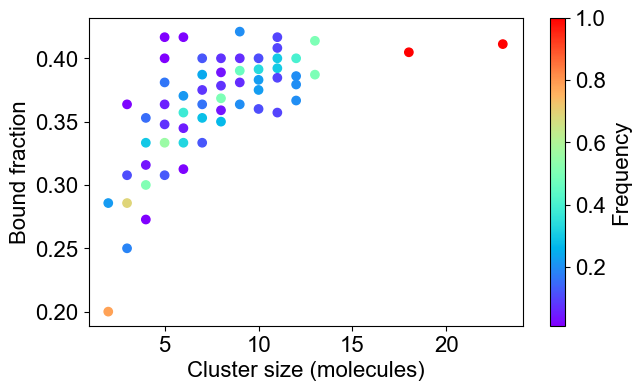

In [7]:
# 2C: Bound fraction distribution
plotBoundFraction(outpath)

### 3. Plot molecule specific quantities

#### 3A. What is the average composition of the clusters?
Apart from the cluster size distribution, it might be useful to know the composition of the clusters.
* Relative fraction of each molecular type within a given cluster size. **The summation of fractions is 1 for each cluster.** 
* For large cluster size range, it might be of interest to inspect composition of a list of special clusters 

*Width* sets the thickness of the bars and *alpha* sets the transparency. 

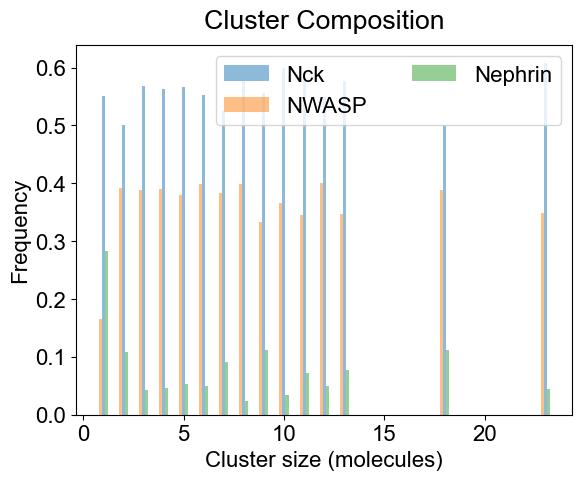

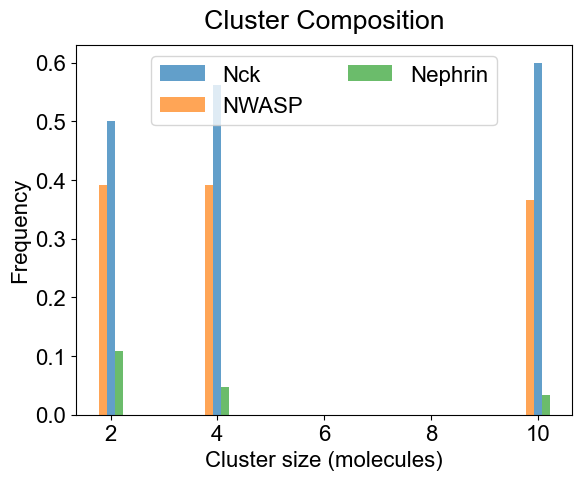

In [8]:
# 3A. Average composition of indivual clusters. 
# Default is all the clusters present in the system. As before, adjust width and transparency (alpha) for visual clarity.
plotClusterComposition(outpath, specialClusters=[], width=0.15, alpha=0.5)

# You can look at the composition of a set of clusters (specialClusters) also
plotClusterComposition(outpath, specialClusters=[2, 4, 10], width=0.15, alpha=0.7)

#### 3B. How many bonds are coming out of each molecular types?
Similar to plot 2C. This one shows the degree of crosslinking of individual molecular types. 

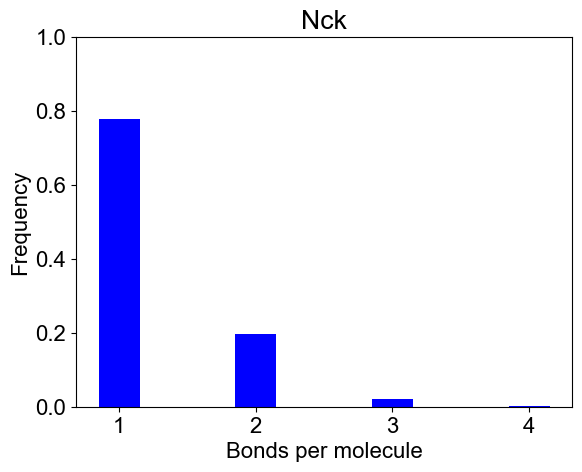

In [9]:
# 3B. Bondcount distribution of each molecular type 
# plotBondCounts(outpath, molecules=molecules) # Reading molecules from previous block

# You may provide a subset of molecules also
plotBondCounts(outpath, molecules=['Nck'])